# Play color
June, ??st, 2021

**Motivation**: There are two motivations:<br>
1) Show content of a parcellation using **pyinspect**<br>
2) Find an **automated** way of **assigning color** to hierarchical clusters

In [1]:
# HIDE CODE


import os
import sys
import ants
import nrrd
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import networkx as nx
import operator as op
from time import time
from rich import print
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from analysis.cluster import Clusters
from analysis.hierarchical import *
from analysis.network import *
from utils.plotting import *
from utils.render import *
from utils.registration import *
from model.mouse import Mice

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_parcellation(
    parcellation: np.ndarray,
    mask_l: np.ndarray,
    mask_r: np.ndarray,
    root_mask: np.ndarray,
    figsize=(6, 4),
    cmap='turbo', ):

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    for i in range(2):
        for j in range(3):
            x = parcellation.copy()

            if i == 0:
                x[mask_r] = 0
                label = 'left\n'
            else:
                x[mask_l] = 0
                # x[x != 0] -= int(np.max(parcellation) // 2)
                label = 'right\n'

            if j == 0:
                title = 'coronal'
            elif j == 1:
                title = 'axial'
            else:
                title = 'saggital'

            data2plt = np.ma.masked_where(~root_mask.astype(bool), x)
            axes[i, j].imshow(data2plt.mean(j), cmap=cmap)

            list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(title, fontsize=17, y=1.2)
            else:
                axes[i, j].set_title('')
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=17)

    fig.tight_layout()
    plt.show()
    
    return fig, axes


def plot_registration(
    fixed: np.ndarray,
    moving: np.ndarray,
    warped: np.ndarray,
    figsize=(6, 8), ):
    
    sns.set_style('white')
    fig, axes = plt.subplots(3, 3, figsize=figsize)

    for i in range(3):
        for j in range(3):       
            if i == 0:
                x = fixed.numpy()
                label = 'fixed'
            elif i == 1:
                x = moving.numpy()
                label = 'moving'
            else:
                x = warped.numpy()
                label = 'warped'

            if i == 0:
                if j == 0:
                    top_title = 'axis = {:d}\n(coronal)'.format(j)
                elif j == 1:
                    top_title = 'axis = {:d}\n(axial)'.format(j)
                else:
                    top_title = 'axis = {:d}\n(saggital)'.format(j)
                axes[i, j].set_title(top_title, y=1.1, fontsize=13)

            if j == 0:
                axes[i, j].set_ylabel(label + '\n', fontsize=13)

            data2plt = x.mean(j)
            axes[i, j].imshow(data2plt)

            _ = list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    msg = 'Plotting averaged data across different dimensions\n\n'
    msg += '1st row (fixed):  Average template,    shape = {}\n'.format(fixed.shape)
    msg += '2nd row (moving):  Anatomical data,    shape = {}\n'.format(moving.shape)
    msg += '3rd row (warped):  Anatomical data,    shape = {}'.format(warped.shape)
    plt.suptitle(msg, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    return fig, axes


def viz_parcel(parcellation, figsize=(10, 4), bins=80):
    accepted, rejected = [], []
    all_distances_accepted = []
    for i, ctr in parcellation['cluster_centers'].items():
        num_voxels = (parcellation['parcel'] == i).sum()
        num_accepted = (parcellation['eroded'] == i).sum()    

        accepted.append(num_accepted) 
        rejected.append(num_voxels - num_accepted)

        points = np.array(tuple(zip(*np.where(parcellation['eroded'] == i))))
        d = sp_dist.cdist(ctr.reshape(-1, 3), points.reshape(-1, 3)).flatten()
        all_distances_accepted.extend(list(d))


    fig, axes = create_figure(1, 2, figsize, style='whitegrid')

    sns.histplot(rejected, color='C7', label='rejected', alpha=0.3, ax=axes[0])
    sns.histplot(accepted, color='C2', label='accepted', alpha=0.7, ax=axes[0])
    _min = np.min(accepted)
    _median = np.median(accepted)
    _max = np.max(accepted)
    axes[0].axvline(_min, color='C4', ls='--', lw=1.3, label=f"min: {_min}")
    axes[0].axvline(_median, color='C3', ls='--', lw=1.5, label=f"median: {_median}")
    axes[0].axvline(_max, color='C4', ls='--', lw=1.3, label=f"max: {_max}")
    axes[0].set_title('distribution of ROI sizes', fontsize=15, y=1.03)
    axes[0].set_xlabel('num voxels', fontsize=14)
    axes[0].legend()

    y, bin_edges = np.histogram(all_distances_accepted, bins=bins)
    x = (bin_edges[1:] + bin_edges[:-1]) / 2
    m, b = np.polyfit(x[y > 0], np.log2(y[y > 0]), 1)
    
    sns.histplot(
        all_distances_accepted, color='C6', stat='count',
        kde=True, line_kws={'lw': 4, 'label': f"fitted slope (log2): {np.round(m, 2)}"}, ax=axes[1]
    )
    axes[1].axvline(
        parcellation['radius'], color='k',
        label=f"max radius: {np.round(parcellation['radius'], 2)}",
        ls='--', lw=2
    )
    axes[1].set_xscale('log', base=2)
    axes[1].set_yscale('log', base=2)
    axes[1].set_title('voxel distances from ROI ctrs (eroded)', fontsize=15, y=1.03)
    axes[1].set_xlabel('r', fontsize=14)
    axes[1].legend(fontsize=13)

    fig.tight_layout()
    plt.show()

## Allen & Atlas

In [3]:
mice = Mice()
allen = load_allen()
atlas = fix_br_atlas()
atlas.space

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


<BGSpace AnatomicalSpace object>
origin: ('Anterior', 'Superior', 'Left')
sections: ('Frontal plane', 'Horizontal plane', 'Sagittal plane')
shape: (132, 80, 114)

## Compute ROIs

In [4]:
n_hemisphere_regions = 64

parcellation = kmeans_parcellation(
    mask=allen['isocortex_mask'],
    n_hemisphere_regions=n_hemisphere_regions,
    symmetrize=False,
    left_right_axis=2,
    random_state=42,
)
parcellation.keys()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


dict_keys(['parcel', 'eroded', 'eroded_masks', 'cluster_centers', 'mask_l', 'mask_r', 'n_cortical_regions', 'radius'])

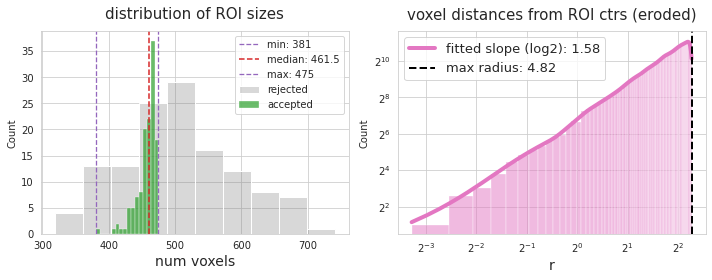

In [5]:
viz_parcel(parcellation)

### ROI mask

In [6]:
roi_masks, major_masks = get_roi_masks(parcellation, allen)

id: 477,	name: Striatum
id: 803,	name: Pallidum
id: 698,	name: Olfactory areas
id: 703,	name: Cortical subplate
id: 1089,	name: Hippocampal formation
id: 315,	name: Isocortex


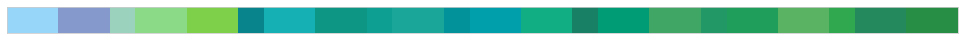

In [7]:
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}
struct_cmap = make_cmap(
    ramp_colors=list(struct_colors.values()),
    n_colors=len(struct_colors),
    name='structs',
)

## Load func data

In [8]:
df = pd.read_pickle(pjoin(tmp_dir, 'func_data.df'))

df_table = {}
for key, (subject, session, run) in mice.looper.items():
    selected_df = df.loc[
        (df.subject == subject) &
        (df.session == session) &
        (df.run == run)
    ]
    if len(selected_df):
        df_table[key] = selected_df.pivot(index='timepoint', columns='region_id', values='bold')
        
df_combined = pd.concat(df_table.values())
node_labels = df_combined.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.shape, df_combined.shape

((3187800, 7), (23100, 138))

## Hierarchical clustering

In [9]:
hier_results = hierarchical_cluster(
    df=df_combined,
    method='ward',
    dist_metric='canberra',
    link_metric='canberra',
)
labels = translate_labels(hier_results['labels'], allen['mcc'])

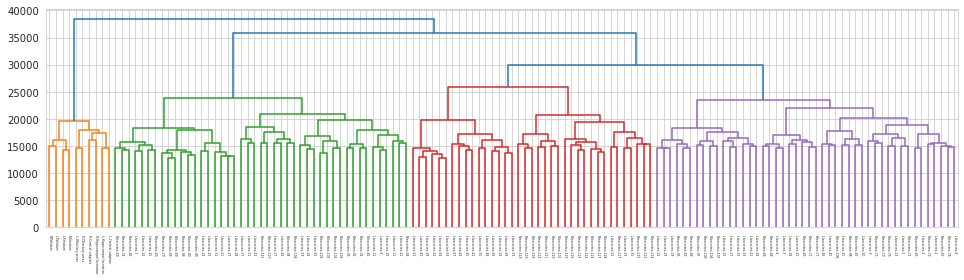

In [10]:
hier_output = get_clust_graph(
    linkage_mat=hier_results['z'],
    labels=labels,
    num_clusters=0,
    leaf_font_size=3,
    orientation='top',
    figsize=(13.5, 4),
)
display(hier_output['fig'])

In [11]:
sns.color_palette('tab20c', n_colors=20)

### All clusters

In [12]:
cluster_color_idxs = {
    2: [17, 0],
    3: [17, 4, 12], 
    4: [17, 8, 4, 12],
    5: [17, 8, 4, 6, 12],
    6: [17, 8, 10, 4, 6, 12],
    7: [17, 8, 10, 4, 6, 12, 14],
    8: [17, 8, 10, 4, 6, 12, 14, 15],
    9: [17, 8, 10, 11, 4, 6, 12, 14, 15],
    10: [17, 8, 10, 11, 4, 6, 7, 12, 14, 15],
    11: [17, 8, 10, 11, 4, 6, 7, 12, 13, 14, 15],
    12: [17, 8, 9, 10, 4, 5, 6, 7, 12, 13, 14, 15],
    13: [17, 8, 9, 10, 11, 4, 5, 6, 7, 12, 13, 14, 15],
    14: [16, 17, 8, 9, 10, 11, 4, 5, 6, 7, 12, 13, 14, 15],
}
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}

n_clusters = 2

#1f77b4,"['(10)', '(128)']"


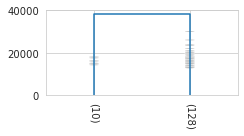

n_clusters = 3

#1f77b4,"['(10)', '(45)', '(83)']"


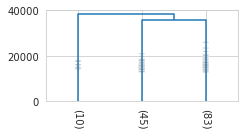

n_clusters = 4

#1f77b4,"['(10)', '(45)', '(37)', '(46)']"


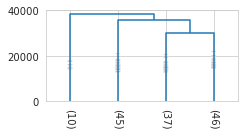

n_clusters = 5

#1f77b4,"['(10)', '(45)', '(46)']"
#ff7f0e,"['(16)', '(21)']"


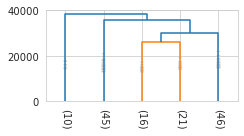

n_clusters = 6

#1f77b4,"['(10)', '(46)']"
#ff7f0e,"['(19)', '(26)']"
#2ca02c,"['(16)', '(21)']"


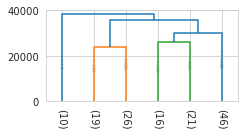

n_clusters = 7

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(26)']"
#2ca02c,"['(16)', '(21)']"
#d62728,"['(16)', '(30)']"


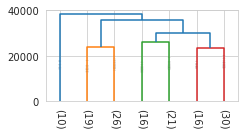

n_clusters = 8

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(26)']"
#2ca02c,"['(16)', '(21)']"
#d62728,"['(16)', '(9)', '(21)']"


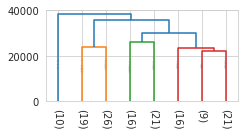

n_clusters = 9

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(17)']"
#2ca02c,"['(16)', '(21)']"
#d62728,"['(21)', '(16)', '(9)']"


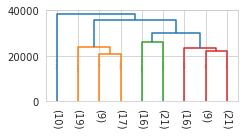

n_clusters = 10

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(17)']"
#2ca02c,"['(16)', '(7)', '(14)']"
#d62728,"['(9)', '(21)', '(16)']"


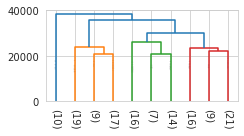

n_clusters = 11

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(17)']"
#2ca02c,"['(16)', '(7)', '(14)']"
#d62728,"['(9)', '(7)', '(14)', '(16)']"


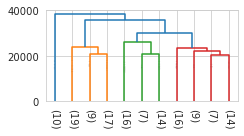

n_clusters = 12

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(17)']"
#2ca02c,"['(6)', '(10)', '(7)', '(14)']"
#d62728,"['(16)', '(9)', '(7)', '(14)']"


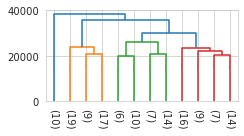

n_clusters = 13

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(7)', '(10)']"
#2ca02c,"['(14)', '(6)', '(10)', '(7)']"
#d62728,"['(16)', '(9)', '(7)', '(14)']"


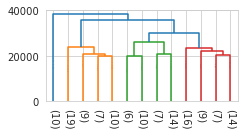

n_clusters = 14

#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(19)', '(9)', '(7)', '(10)']"
#d62728,"['(7)', '(14)', '(6)', '(10)']"
#9467bd,"['(16)', '(9)', '(7)', '(14)']"


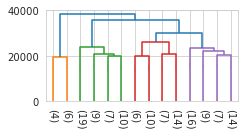

In [13]:
clusters_all = {}

for n_clusters in range(2, 15):
    hier_output = get_clust_graph(
        linkage_mat=hier_results['z'],
        c_list=cluster_color_idxs[n_clusters],
        labels=labels,
        num_clusters=n_clusters,
        leaf_font_size=10,
        figsize=(3.5, 2),
    )
    print(f"n_clusters = {n_clusters}")
    display(hier_output['cluster_classes'])
    display(hier_output['fig'])
    print('\n')
    
    community = {
        i: translate_labels(leaves, allen['mcc'], forward=False)
        for i, leaves in hier_output['cluster_assigns'].items()
    }
    assert len(community) == n_clusters

    comms3d = np.zeros(allen['template'].shape)
    for cluster_idx, leaves in community.items():
        for lbl in leaves:
            if str(allen['isocortex']['id']) in lbl:
                lr, structure_id, region_id = tuple(map(lambda x: int(x), lbl.split('-')))
                comms3d[parcellation['parcel'] == region_id] = cluster_idx
            else:
                comms3d[roi_masks[lbl]] = cluster_idx
    comms3d = comms3d.astype(int)
    
    # save results
    cluster = Clusters(
        x=comms3d,
        masks=major_masks,
        c_cluster=hier_output['cluster_colors'],
        c_structure=struct_colors,
        threshold=0.0,
    )
    clusters_all[n_clusters] = cluster
    
    with open(pjoin(tmp_dir, f"table-regions_n-{n_clusters}.html"), 'w') as f:
        f.write(cluster.repr_html_regions())
    with open(pjoin(tmp_dir, f"table-clusters_n-{n_clusters}.html"), 'w') as f:
        f.write(cluster.repr_html_clusters())

In [14]:
cl = clusters_all[14]
cl.set_display('regions')
cl

STR C_1 100% PAL C_1 100% OLF C_2 100% CTXsp C_2 100% HPF C_2 100% VIS C_9 44% C_8 30% C_7 18% C_10 7% C_11 1% TEa C_3 46% C_8 18% C_9 18% C_7 9% C_10 6% C_4 5% PERI C_3 93% C_9 6% C_8 1% ECT C_3 92% C_9 6% C_8 2% RSP C_9 57% C_12 27% C_11 8% C_8 5% C_7 3% AUD C_10 44% C_7 44% C_3 6% C_8 3% C_9 2% C_4 1% PTLp C_7 41% C_11 36% C_10 20% C_9 3% VISC C_3 71% C_4 14% C_6 13% C_7 1% SS C_6 34% C_11 21% C_4 18% C_10 10% C_7 9% C_5 8% GU C_6 39% C_3 36% C_14 25% ACA C_12 60% C_13 30% C_11 10% C_5 1% AI C_14 64% C_3 30% C_6 4% C_13 2% MO C_5 27% C_11 25% C_6 24% C_13 16% C_14 6% C_12 2% ILA C_13 100% PL C_13 98% C_5 2% ORB C_13 78% C_14 21% C_5 1% FRP C_14 53% C_13 44% C_5 3%

In [15]:
cl.set_threshold(20)
cl.set_display('clusters')
cl

C_1 STR 100% PAL 100% C_2 OLF 100% CTXsp 100% HPF 100% C_3 PERI 93% ECT 92% VISC 71% TEa 46% GU 36% AI 30% C_4 C_5 MO 27% C_6 GU 39% SS 34% MO 24% C_7 AUD 44% PTLp 41% C_8 VIS 30% C_9 RSP 57% VIS 44% C_10 AUD 44% C_11 PTLp 36% MO 25% SS 21% C_12 ACA 60% RSP 27% C_13 ILA 100% PL 98% ORB 78% FRP 44% ACA 30% C_14 AI 64% FRP 53% GU 25% ORB 21%

## Render

In [16]:
for n_clusters in range(2, 15): 
    _ = cluster2html(
        cluster=clusters_all[n_clusters],
        save_name='canberra',
        n_cortex_regions=parcellation['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-2.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-3.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-4.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-5.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-6.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-7.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-8.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-9.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-10.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-11.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-12.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-13.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-14.html

## Color play

In [14]:
sns.color_palette('tab20c', n_colors=20)

Bu

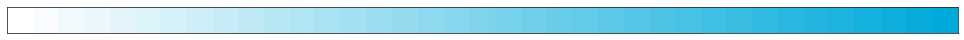

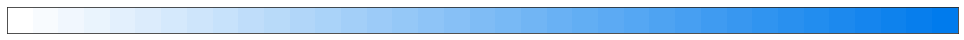

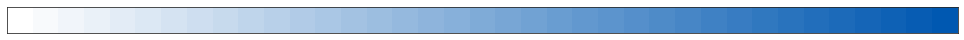

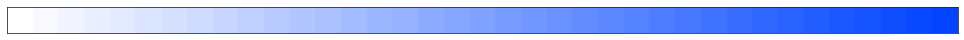

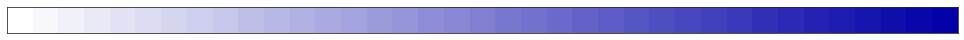

Gn

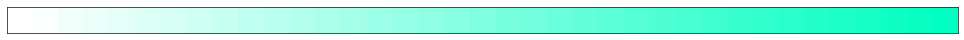

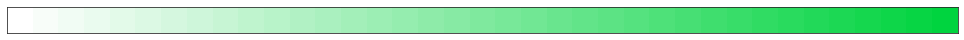

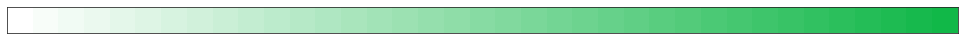

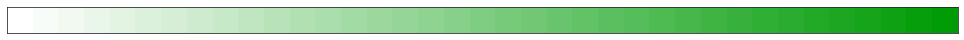

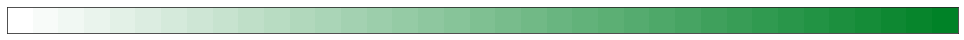

YlOrRd

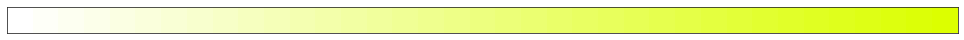

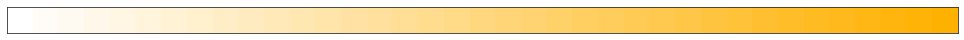

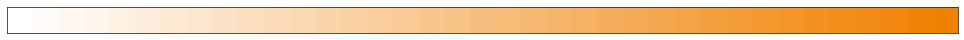

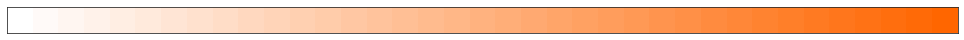

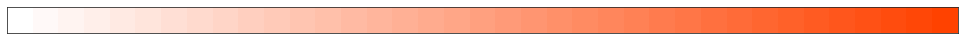

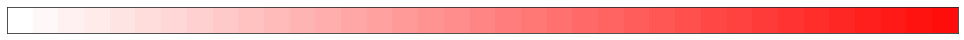

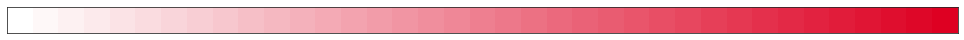

Pu

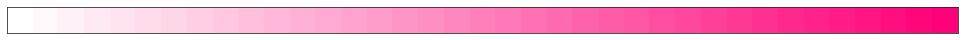

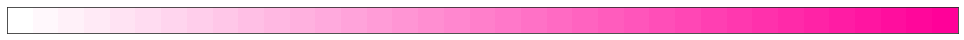

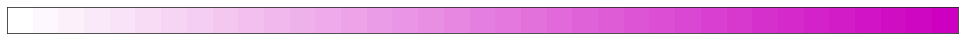

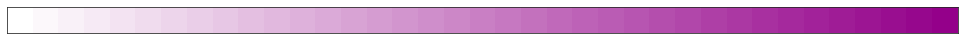

Other

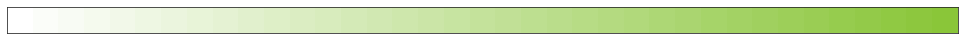

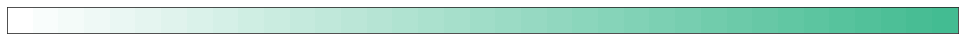

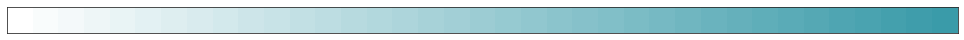

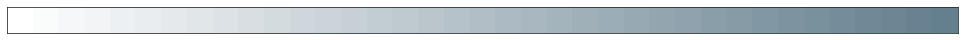

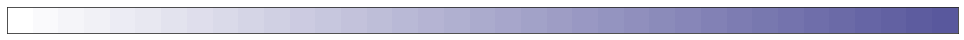

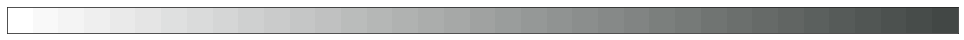

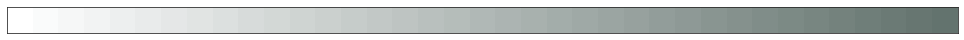

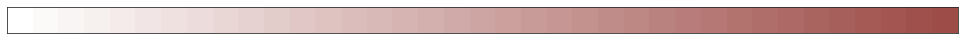

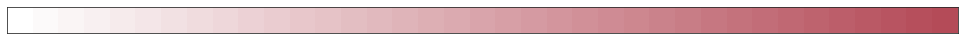

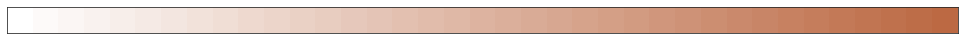

In [15]:
n_colors = 256
white = '#FFFFFF'

Bu = ['#00AADB', '#007bed', '#0058B1', '#0044ff', '#0200A7']
Gn = ['#00ffc2', '#00D43F', '#11B848', '#009C06', '#008227']
YlOrRd = ['#DCFF00', '#FFB100', '#F18100', '#FF6600', '#FF4200', '#FF0D0A', '#DE0022']
Pu = ['#FF0078', '#FF0199', '#CD00C1', '#94008A']
Other = ['#8AC639', '#43BC92', '#3A9BA9', '#647F8E',
         '#59589D', '#424745', '#63736E', '#9D4C47', '#B44B58', '#BC6943']

candidate_colors = {
    'Bu': Bu,
    'Gn': Gn,
    'YlOrRd': YlOrRd,
    'Pu': Pu,
    'Other': Other,
}
for k, c_list in candidate_colors.items():
    print(k)
    for c in c_list:
        ramp_colors = [white, c]
        custom_cmap = make_cmap(
            ramp_colors=ramp_colors,
            n_colors=n_colors,
            name='custom',
        )

In [16]:
{k: len(v) for k, v in candidate_colors.items()}

{'Bu': 5, 'Gn': 5, 'YlOrRd': 7, 'Pu': 4, 'Other': 10}

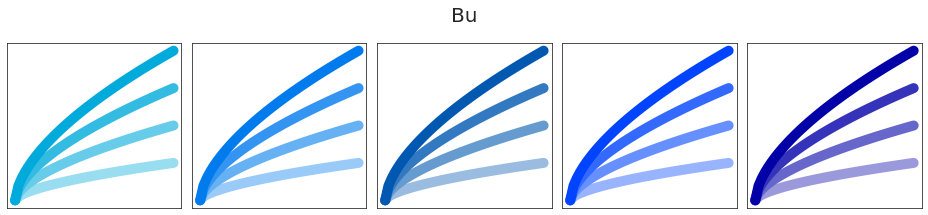

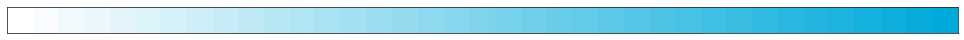

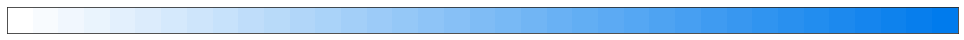

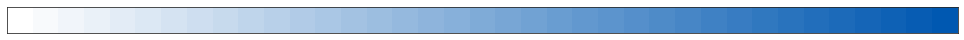

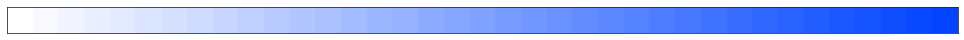

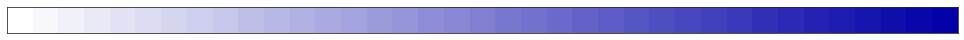

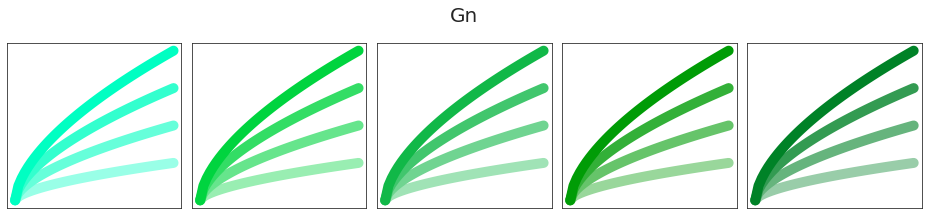

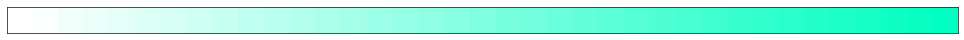

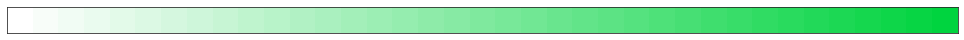

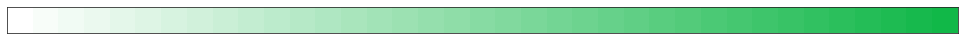

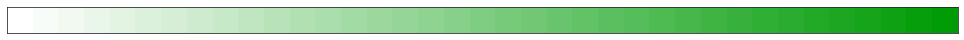

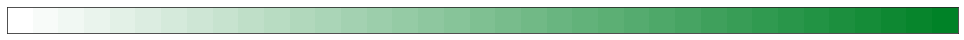

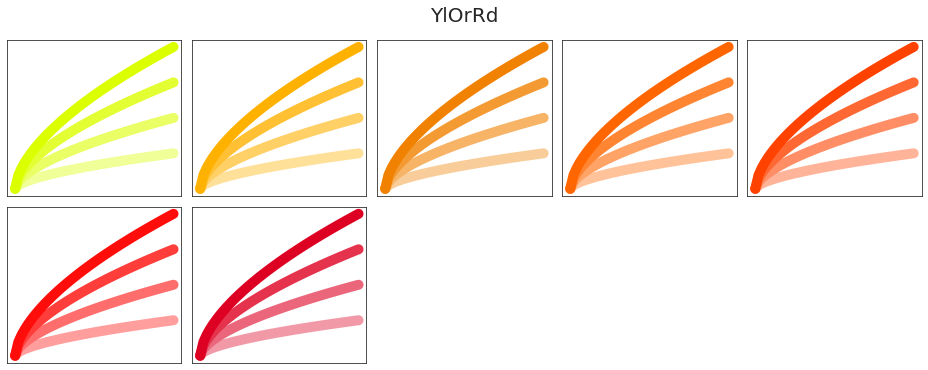

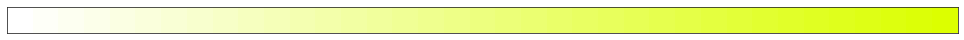

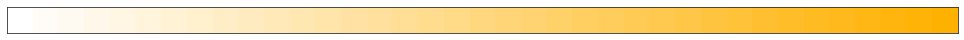

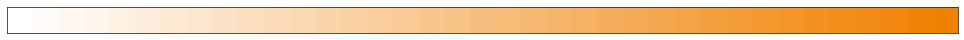

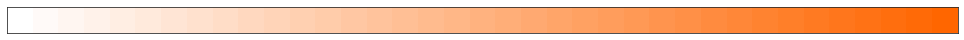

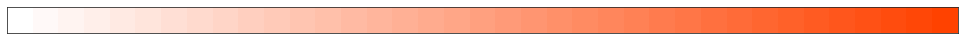

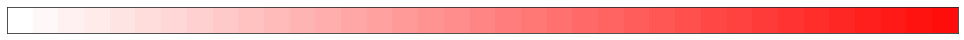

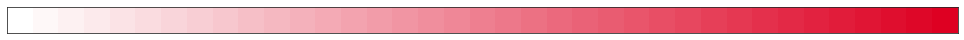

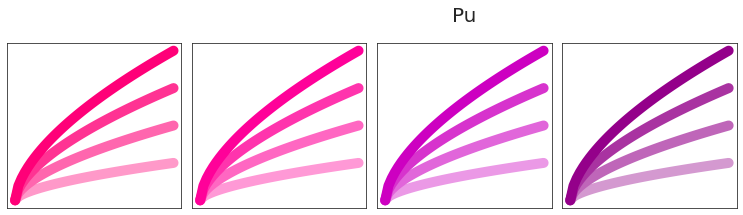

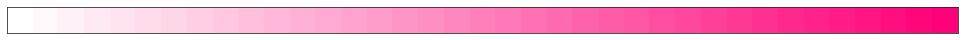

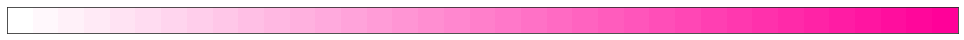

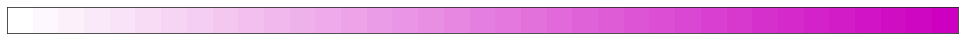

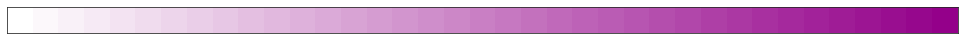

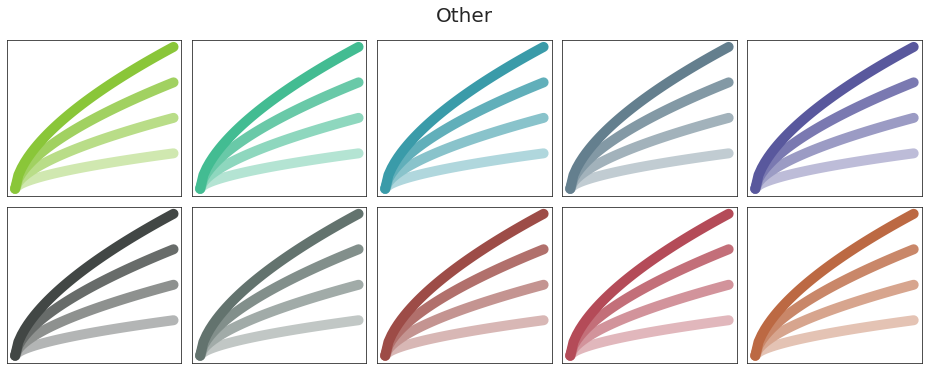

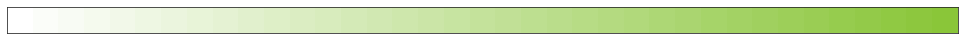

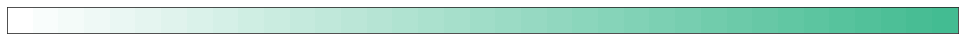

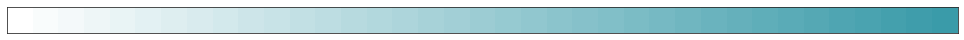

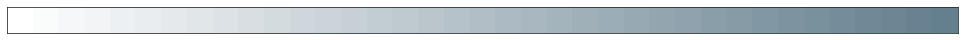

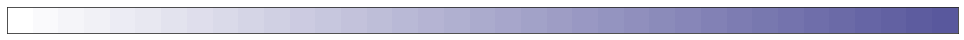

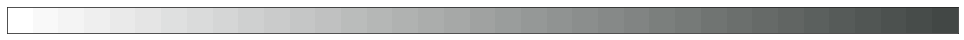

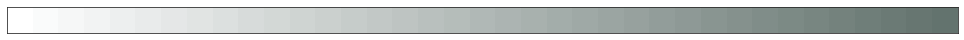

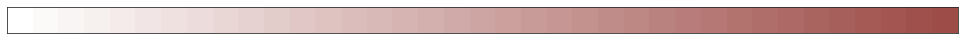

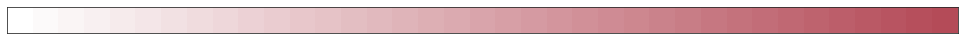

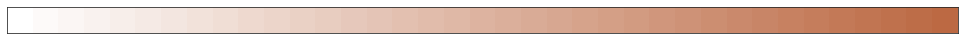

In [17]:
ncols = 5
x = np.linspace(0, 1)
y = x**0.6

for k, c_list in candidate_colors.items():
    nrows = int(np.ceil(len(c_list) / ncols))
    sz = 5.2 if nrows == 2 else 3
    fig, axes = create_figure(nrows, ncols, (13, sz), sharex='all', sharey='all')
    cmaps = []
    for c, ax in zip(c_list, axes.flatten()):
        ramp_colors = [white, c]
        custom_cmap = make_cmap(
            ramp_colors=ramp_colors,
            n_colors=n_colors,
            name='custom',
            show=False,
        )
        cmaps.append(custom_cmap)
        # colors = [rgb2hex(custom_cmap(x)) for x in ]
        for i, r in enumerate([0.4, 0.60, 0.8, 1.0]):
            ax.plot(x, y * (i+1), color=rgb2hex(custom_cmap(r)), lw=10)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(k, fontsize=20)
    fig.tight_layout()
    trim_axs(axes, len(c_list))
    plt.show()
    
    for cmap in cmaps:
        display_cmap(cmap)
    
    print('\n\n')

In [18]:
import colorsys

In [26]:
hsv = (1, 0.8, 1)
rgb = colorsys.hsv_to_rgb(*hsv)
hx = rgb2hex(rgb)

In [27]:
hx

'#ff3333'

## Report properties of a parcellation (TODO)
> use this:
```Python
import pyinspect as pi
```

In [ ]:
    def content(self):
        """
        Prints an overview of the Actors in the scene.
        """

        actors = pi.Report(
            "Scene actors", accent=salmon, dim=orange, color=orange
        )

        for act in self.actors:
            actors.add(
                f"[bold][{amber}]- {act.name}[/bold][{orange_darker}] "
                f"(type: [{orange}]{act.br_class}[/{orange}]) "
                f"(color: [{orange}]{rgb2hex(act.mesh.c())}[/{orange}]) "
                f"(alpha: [{orange}]{act.mesh.alpha()}[/{orange}]) "
            )

        if "win32" != sys.platform:
            actors.print()
        else:
            print(pi.utils.stringify(actors, maxlen=-1))